In [1]:
import numpy as np
import cv2 as cv
from scipy.ndimage import interpolation as inter
from PIL import Image as im


def binary_otsus(image, filter:int=1):
    """Binarize an image 0's and 255's using Otsu's Binarization"""

    if len(image.shape) == 3:
        gray_img = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    else:
        gray_img = image

    # Otsus Binarization
    if filter != 0:
        blur = cv.GaussianBlur(gray_img, (3,3), 0)
        binary_img = cv.threshold(blur, 0, 255, cv.THRESH_BINARY+cv.THRESH_OTSU)[1]
    else:
        binary_img = cv.threshold(gray_img, 0, 255, cv.THRESH_BINARY+cv.THRESH_OTSU)[1]
    
    # Morphological Opening
    # kernel = np.ones((3,3),np.uint8)
    # clean_img = cv.morphologyEx(binary_img, cv.MORPH_OPEN, kernel)

    return binary_img


def find_score(arr, angle):
    data = inter.rotate(arr, angle, reshape=False, order=0)
    hist = np.sum(data, axis=1)
    score = np.sum((hist[1:] - hist[:-1]) ** 2)
    return hist, score

def deskew(binary_img):

    
    ht, wd = binary_img.shape
    # _, binary_img = cv.threshold(img, 127, 255, cv.THRESH_BINARY)

    # pix = np.array(img.convert('1').getdata(), np.uint8)
    bin_img = (binary_img // 255.0)

    delta = 0.1
    limit = 3
    angles = np.arange(-limit, limit+delta, delta)
    scores = []
    for angle in angles:
        hist, score = find_score(bin_img, angle)
        scores.append(score)

    best_score = max(scores)
    best_angle = angles[scores.index(best_score)]
    # print('Best angle: {}'.formate(best_angle))

    # correct skew
    data = inter.rotate(bin_img, best_angle, reshape=False, order=0)
    img = im.fromarray((255 * data).astype("uint8"))

    # img.save('skew_corrected.png')
    pix = np.array(img)
    return pix

def vexpand(gray_img, color:int):
    """Expand the image by some space vertically in both directions"""

    color = 1 if color > 0 else 0
    (h, w) = gray_img.shape[:2]
    space = np.ones((10, w)) * 255 * color

    return np.block([[space], [gray_img], [space]])


def hexpand(gray_img, color:int):
    """Expand the image by some space horizontally in both directions"""

    color = 1 if color > 0 else 0
    (h, w) = gray_img.shape[:2]
    space = np.ones((h, 10)) * 255 * color

    return np.block([space, gray_img, space])

def valid(row, col, vis, word):
    return (row < vis.shape[0] and col < vis.shape[1] and row >= 0 and col >=0 and vis[row][col] == 0 and word[row][col] > 0)

def dfs(row, col, vis, word):

    dX = [0,0,1,1,-1,-1,1,-1]
    dY = [1,-1,0,1,0,-1,-1,1]
    vis[row][col] += 1
    for i in range(8):
        if(valid(row+dX[i],col+dY[i],vis, word)):
            dfs(row+dX[i], col+dY[i], vis, word)
    return


In [2]:
import numpy as np
import cv2 as cv


def save_image(img, folder, title):
    cv.imwrite(f'./{folder}/{title}.png', img)


def projection(gray_img, axis:str='horizontal'):
    """ Compute the horizontal or the vertical projection of a gray image """

    if axis == 'horizontal':
        projection_bins = np.sum(gray_img, 1).astype('int32')
    elif axis == 'vertical':
        projection_bins = np.sum(gray_img, 0).astype('int32')

    return projection_bins

In [4]:
import numpy as np
import cv2 as cv
from glob import glob


def preprocess(image):

    # Maybe we end up using only gray level image.
    gray_img = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    gray_img = cv.bitwise_not(gray_img)

    binary_img = binary_otsus(gray_img, 0)
    # cv.imwrite('origin.png', gray_img)

    # deskewed_img = deskew(binary_img)
    deskewed_img = deskew(binary_img)
    # cv.imwrite('output.png', deskewed_img)

    # binary_img = binary_otsus(deskewed_img, 0)
    # breakpoint()

    # Visualize

    # breakpoint()
    return deskewed_img


def projection_segmentation(clean_img, axis, cut=3):
    
    segments = []
    start = -1
    cnt = 0

    projection_bins = projection(clean_img, axis)
    for idx, projection_bin in enumerate(projection_bins):

        if projection_bin != 0:
            cnt = 0
        if projection_bin != 0 and start == -1:
            start = idx
        if projection_bin == 0 and start != -1:
            cnt += 1
            if cnt >= cut:
                if axis == 'horizontal':
                    segments.append(clean_img[max(start-1, 0):idx, :])
                elif axis == 'vertical':
                    segments.append(clean_img[:, max(start-1, 0):idx])
                cnt = 0
                start = -1
    
    return segments


# Line Segmentation
#----------------------------------------------------------------------------------------
def line_horizontal_projection(image, cut=3):

    # Preprocess input image
    clean_img = preprocess(image)


    # Segmentation    
    lines = projection_segmentation(clean_img, axis='horizontal', cut=cut)

    return lines


# Word Segmentation
#----------------------------------------------------------------------------------------
def word_vertical_projection(line_image, cut=3):
    
    line_words = projection_segmentation(line_image, axis='vertical', cut=cut)
    line_words.reverse()
    
    return line_words


def extract_words(img, visual=0):

    lines = line_horizontal_projection(img)
    words = []
    
    for idx, line in enumerate(lines):
        
        if visual:
            save_image(line, 'lines', f'line{idx}')

        line_words = word_vertical_projection(line)
        for w in line_words:
            # if len(words) == 585:
            #     print(idx)
            words.append((w, line))
        # words.extend(line_words)

    # breakpoint()
    if visual:
        for idx, word in enumerate(words):
            save_image(word[0], 'words', f'word{idx}')

    return words


if __name__ == "__main__":
    
    img = cv.imread('fonts-dataset/IBM Plex Sans Arabic/21.jpeg')
    extract_words(img, 1)

C:\Users\malek\AppData\Local\Temp\ipykernel_32568\57911148.py:30: DeprecationWarning: Please import `rotate` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  data = inter.rotate(arr, angle, reshape=False, order=0)
C:\Users\malek\AppData\Local\Temp\ipykernel_32568\57911148.py:57: DeprecationWarning: Please import `rotate` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  data = inter.rotate(bin_img, best_angle, reshape=False, order=0)


C:\Users\malek\AppData\Local\Temp\ipykernel_32568\57911148.py:30: DeprecationWarning: Please import `rotate` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  data = inter.rotate(arr, angle, reshape=False, order=0)
C:\Users\malek\AppData\Local\Temp\ipykernel_32568\57911148.py:57: DeprecationWarning: Please import `rotate` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  data = inter.rotate(bin_img, best_angle, reshape=False, order=0)


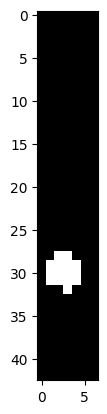

In [21]:
import numpy as np
import cv2 as cv
from skimage.morphology import skeletonize, thin


def binarize(word_img):

    _, binary_img = cv.threshold(word_img, 127, 255, cv.THRESH_BINARY)
    # _, binary_img = cv.threshold(word_img, 0, 255, cv.THRESH_BINARY+cv.THRESH_OTSU)

    return binary_img // 255


def fill(binary_img, VP):

    (h, w) = binary_img.shape

    flag = 1
    while flag:
        flag = 0
        for row in range(h-1):
            for col in range(1, w-1):

                if binary_img[row][col] == 0 and binary_img[row][col-1] == 1 and binary_img[row][col+1] == 1 and binary_img[row+1][col] == 1 and VP[col] != 0:
                    binary_img[row][col] = 1
                    # flag = 1

    return binary_img
    

def baseline_detection(word_img):
    '''Get baseline index of a given word'''

    HP = projection(word_img, 'horizontal')
    peak = np.amax(HP)

    # Array of indices of max element
    baseline_idx = np.where(HP == peak)[0]

    # Get first or last index
    upper_base = baseline_idx[0]
    lower_base = baseline_idx[-1]
    thickness = abs(lower_base - upper_base) + 1
    
    return upper_base, lower_base, thickness


def horizontal_transitions(word_img, baseline_idx):
    
    max_transitions = 0
    max_transitions_idx = baseline_idx
    line_idx = baseline_idx-1
    lines = []
    # new temp image with no dots above baseline
    
    while line_idx >= 0:
        current_transitions = 0
        flag = 0

        horizontal_line = word_img[line_idx, :]
        for pixel in reversed(horizontal_line):

            if pixel == 1 and flag == 0:
                current_transitions += 1
                flag = 1
            elif pixel == 0 and flag == 1:
                current_transitions += 1
                flag = 0
                
        if current_transitions >= max_transitions:
            max_transitions = current_transitions
            lines.append(line_idx)
            max_transitions_idx = line_idx

        line_idx -= 1
    
    return lines[len(lines)//2]


def vertical_transitions(word_img, cut):
    
    transitions = 0

    vertical_line = word_img[:, cut]

    flag = 0
    for pixel in vertical_line:

        if pixel == 1 and flag == 0:
            transitions += 1
            flag = 1
        elif pixel == 0 and flag == 1:
            transitions += 1
            flag = 0

    return transitions


def cut_points(word_img, VP, MFV, MTI, baseline_idx):
      
    # flag to know the start of the word
    f = 0

    flag = 0
    (h, w) = word_img.shape
    i = w-1
    separation_regions = []

    wrong = 0
    # loop over the width of the image from right to left
    while i >= 0:

        pixel = word_img[MTI, i]
        
        if pixel == 1 and f == 0:
            f = 1
            flag = 1

        if f == 1:

            # Get start and end of separation region (both are black pixels <----)
            if pixel == 0 and flag == 1:
                start = i+1
                flag = 0
            elif pixel == 1 and flag == 0:
                end = i         # end maybe = i not i+1
                flag = 1

                mid = (start + end) // 2

                left_zero = -1
                left_MFV = -1
                right_zero = -1
                right_MFV = -1
                # threshold for MFV
                T = 1

                j = mid - 1
                # loop from mid to end to get nearest VP = 0 and VP = MFV
                while j >= end:
                    
                    if VP[j] == 0 and left_zero == -1:
                        left_zero = j
                    if VP[j] <= MFV + T and left_MFV == -1:
                        left_MFV = j

                    # if left_zero != -1 and left_MFV != -1:
                    #     break

                    j -= 1

                j = mid
                # loop from mid to start to get nearest VP = 0 and VP = MFV
                while j <= start:

                    if VP[j] == 0 and right_zero == -1:
                        right_zero = j
                    if VP[j] <= MFV + T and right_MFV == -1:
                        right_MFV = j

                    if right_zero != -1 and right_MFV != -1:
                        break

                    j += 1

                # Check for VP = 0 first
                if VP[mid] == 0:
                    cut_index = mid
                elif left_zero != -1 and right_zero != -1:
                    
                    if abs(left_zero-mid) <= abs(right_zero-mid):
                        cut_index = left_zero
                    else:
                        cut_index = right_zero
                elif left_zero != -1:
                    cut_index = left_zero
                elif right_zero != -1:
                    cut_index = right_zero

                # Check for VP = MFV second
                # elif VP[mid] <= MFV+T:
                #     cut_index = mid
                elif left_MFV != -1:
                    cut_index = left_MFV
                elif right_MFV != -1:
                    cut_index = right_MFV
                else:
                    cut_index = mid


                seg = word_img[:, end:start]
                HP = projection(seg, 'horizontal')
                SHPA = np.sum(HP[:MTI])
                SHPB = np.sum(HP[MTI+1:])
                
                top = 0
                for idx, proj in enumerate(HP):
                    if proj != 0:
                        top = idx
                        break

                cnt = 0
                for k in range(end, cut_index+1):
                    if vertical_transitions(word_img, k) > 2:
                        cnt = 1
                if SHPB == 0 and (baseline_idx - top) <= 5 and cnt == 1:
                    # breakpoint()
                    wrong = 1
                else:
                    separation_regions.append((end, cut_index, start))

        i -= 1

    return separation_regions, wrong


def check_baseline(word_img, start, end, upper_base, lower_base):
    
    j = end+1

    cnt = 0
    while j < start:
    
        # Black pixel (Discontinuity)
        base = upper_base
        while base <= lower_base:
            
            pixel = word_img[base][j]
            cnt += pixel

            base += 1
        
        j += 1

    if cnt == 0:
        return False

    return True


def inside_hole(word_img, end_idx, start_idx):
    '''Check if a segment has a hole or not'''

    if end_idx == 0 and start_idx == 0:
        return 0

    sk = skeletonize(word_img)
    j = end_idx + 1
    flag = 1
    while j < start_idx:
        VT = vertical_transitions(sk, j)
        if VT <= 2:
            flag = 0
            break
        j += 1
    
    return flag


def check_hole(segment):
    '''Check if a segment has a hole or not'''

    # no_dots = segment.copy()

    contours, hierarchy = cv.findContours(segment, cv.RETR_TREE, cv.CHAIN_APPROX_NONE)
    cnt = 0
    for hier in hierarchy[0]:
        if hier[3] >= 0:
            cnt += 1

    return cnt != 0


def remove_dots(word_img, threshold=11):

    no_dots = word_img.copy()

    components, labels, stats, GoCs = cv.connectedComponentsWithStats(no_dots, connectivity=8)
    char = []
    for label in range(1, components):
        _, _, _, _, size = stats[label]
        if size > threshold:
            char.append(label)
    for label in range(1, components):
        _, _, _, _, size = stats[label]
        if label not in  char:
            no_dots[labels == label] = 0

    return no_dots


def check_dots(segment):

    contours, hierarchy = cv.findContours(segment[:, 1:segment.shape[1]-1], cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

    cnt = 0
    for c in contours:
        if len(c) >= 1:
            cnt +=1 
    return cnt > 1


def check_stroke(no_dots_copy, segment, upper_base, lower_base, SR1, SR2):

    T = 1
    components, labels, stats, cen= cv.connectedComponentsWithStats(segment, connectivity=8)
    skeleton = skeletonize(segment.copy()).astype(np.uint8)
    (h, w) = segment.shape

    cnt = 0
    for label in range(1, components):
        if stats[label][4] > 3:
            cnt += 1
        else:
            segment[labels==label] = 0

    if cnt > 2 or cnt == 0:
        return False

    if check_hole(segment) or inside_hole(no_dots_copy, SR1[0], SR1[1]) or inside_hole(no_dots_copy, SR2[0], SR2[1]):
        return False

    HP = projection(skeleton, 'horizontal')
    VP = projection(segment, 'vertical')

    seg_l = -1
    seg_r = -1
    for i in range(0, len(VP)):
        if VP[i] != 0:
            seg_l = i
            break
    for i in range(len(VP)-1, -1, -1):
        if VP[i] != 0:
            seg_r = i
            break

    seg_width = seg_r - seg_l + 1
    SHPA = np.sum(HP[:upper_base])
    SHPB = np.sum(HP[lower_base+T+1:])
    MFV_HP = np.argmax(np.bincount(HP)[1:])+1
    MFV = lower_base - upper_base + 1 + T

    top_pixel = -1
    for i, proj in enumerate(HP):
        if proj != 0:
            top_pixel = i
            break
    height = upper_base-top_pixel
    
    VT = 0
    for i in range(w):
        if vertical_transitions(skeleton, i) > 2:
            VT += 1
    cnt = 0
    for proj in VP:
        if proj >= height:
            cnt += 2
        elif proj == height-1:
            cnt += 1
    # abs(MFV - MFV_HP) <= 2
    if SHPB == 0  and height <= 6 and VT <= 2 and seg_width <= 6 and cnt >= 2:
        return True

    return False


def filter_regions(word_img, no_dots_copy, SRL:list, VP:list, upper_base:int, lower_base:int, MTI:int, MFV:int, top_line:int):
    
    valid_separation_regions = []
    overlap = []

    T = 1
    components, labels= cv.connectedComponents(word_img[:lower_base+5, :], connectivity=8)

    SR_idx = 0
    while SR_idx < len(SRL):
        
        SR = SRL[SR_idx]
        end_idx, cut_idx, start_idx = SR

        # Case 1 : Vertical Projection = 0
        if VP[cut_idx] == 0:
            valid_separation_regions.append(SR)
            SR_idx += 1
            continue

      # Case 2 : no connected path between start and end
        # components, labels= cv.connectedComponents(word_img[:, end_idx:start_idx+1], connectivity=8)
        if labels[MTI, end_idx] != labels[MTI, start_idx]:
            valid_separation_regions.append(SR)
            overlap.append(SR)
            SR_idx += 1
            continue

      

        # Case 3 : Contain Holes
        # if check_hole(no_dots_copy[:, end_idx: cut_idx]) and inside_hole(no_dots_copy, end_idx, start_idx):
        cc, l = cv.connectedComponents(1-(no_dots_copy[:, end_idx:start_idx+1]), connectivity=4)
        
        if cc-1 >= 3 and inside_hole(no_dots_copy, end_idx, start_idx):
            SR_idx += 1
            continue
       
     
        # Case 4 : No baseline between start and end
        segment = no_dots_copy[:, end_idx+1: start_idx]
        segment_width = start_idx-end_idx-1

        j = end_idx+1
        cnt = 0
        while j < start_idx:
            
            # Black pixel (Discontinuity)
            base = upper_base-T
            while base <= lower_base+T:
                
                pixel = no_dots_copy[base][j]
                cnt += pixel

                base += 1
            
            j += 1

        if cnt < segment_width-2 and segment_width > 4:
            
            segment_HP = projection(segment, 'horizontal')

            SHPA = np.sum(segment_HP[:upper_base])
            SHPB = np.sum(segment_HP[lower_base+T+1:])

            if (int(SHPB) - int(SHPA)) >= 0:
                SR_idx += 1
                continue
            elif VP[cut_idx] <= MFV + T:
                valid_separation_regions.append(SR)
                SR_idx += 1
                continue
            else:
                SR_idx += 1
                continue

      
        # if SR_idx == 0:
        #     breakpoint()
        # Case 5 : Last region or next VP[nextcut] = 0
        if SR_idx == len(SRL) - 1 or VP[SRL[SR_idx+1][1]] == 0:

            if SR_idx == len(SRL) - 1:
                segment_dots = word_img[:, :SRL[SR_idx][1]+1]
                segment = no_dots_copy[:, :SRL[SR_idx][1]+1]
                next_cut = 0
            else:
                next_cut = SRL[SR_idx+1][1]
                segment_dots = word_img[:, next_cut:SRL[SR_idx][1]+1]
                segment = no_dots_copy[:, next_cut:SRL[SR_idx][1]+1]

            segment_HP = projection(segment, 'horizontal')
            (h, w) = segment.shape

            top = -1
            for i, proj in enumerate(segment_HP):
                if proj != 0:
                    top = i
                    break
            height = upper_base - top

            # if SR_idx == len(SRL) - 1:
                # breakpoint()
            SHPA = np.sum(segment_HP[:upper_base])
            SHPB = np.sum(segment_HP[lower_base+T+1:])
            sk = skeletonize(segment).astype(np.uint8)
            seg_VP = projection(segment, 'vertical')
            non_zero =  np.nonzero(seg_VP)[0]
            cnt = 0
            # for k in range(0, (len(non_zero)//2)+(len(non_zero)%2)):
            for k in range(0, 3):
                if k >= len(non_zero):
                    break
                index = non_zero[k]
                if seg_VP[index] >= height:
                    cnt += 1
            
            if (SHPB <= 5 and cnt > 0 and height <= 6) or (len(non_zero) >= 10 and SHPB > SHPA and not check_dots(segment_dots)):
                SR_idx += 1
                continue
                
        # Strokes 

        SEGP = (-1, -1)
        SEG = (-1, -1)
        SEGN = (-1, -1)
        SEGNN = (-1, -1)
        SEGP_SR1 = (0, 0)
        SEGP_SR2 = (0, 0)
        SEG_SR1 = (0, 0)
        SEG_SR2 = (0, 0)
        SEGN_SR1 = (0, 0)
        SEGN_SR2 = (0, 0)
        SEGNN_SR1 = (0, 0)
        SEGNN_SR2 = (0, 0)

        current_cut = SR[1]
     
        if SR_idx == 0:
            SEGP = (SRL[SR_idx][1], word_img.shape[1]-1)
            SEGP_SR1 = (SRL[SR_idx][0], SRL[SR_idx][2])
            SEGP_SR2 = (SRL[SR_idx][1], word_img.shape[1]-1)

        if SR_idx > 0:
            SEGP = (SRL[SR_idx][1], SRL[SR_idx-1][1])
            SEGP_SR1 = (SRL[SR_idx][0], SRL[SR_idx][2])
            SEGP_SR2 = (SRL[SR_idx-1][0], SRL[SR_idx-1][2])
        
        if SR_idx < len(SRL)-1:
            SEG = (SRL[SR_idx+1][1], SRL[SR_idx][1])
            SEG_SR1 = (SRL[SR_idx][0], SRL[SR_idx][2])
            SEG_SR2 = (SRL[SR_idx+1][0], SRL[SR_idx+1][2])

        if SR_idx < len(SRL)-2:
            SEGN = (SRL[SR_idx+2][1], SRL[SR_idx+1][1])
            SEGN_SR1 = (SRL[SR_idx+1][0], SRL[SR_idx+1][2])
            SEGN_SR2 = (SRL[SR_idx+2][0], SRL[SR_idx+2][2])
        elif SR_idx == len(SRL)-2:
            SEGN = (0, SRL[SR_idx+1][1])
            SEGN_SR1 = (SRL[SR_idx+1][0], SRL[SR_idx+1][2])
            SEGN_SR2 = (0, SRL[SR_idx+1][2])

            
        if SR_idx < len(SRL)-3:
            SEGNN = (SRL[SR_idx+3][1], SRL[SR_idx+2][1])
            SEGNN_SR1 = (SRL[SR_idx+2][0], SRL[SR_idx+2][2])
            SEGNN_SR2 = (SRL[SR_idx+3][0], SRL[SR_idx+3][2])

            
        # if SR_idx == 6:
        #     breakpoint()
        
        # SEG is stroke with dots
        if SEG[0] != -1 and\
            (check_stroke(no_dots_copy, no_dots_copy[:, SEG[0]:SEG[1]], upper_base, lower_base, SEG_SR1, SEG_SR2) \
            and check_dots(word_img[:, SEG[0]:SEG[1]])):
            
            # breakpoint()
            # Case when starts with ش
            if SEGP[0] != -1 and \
                ((check_stroke(no_dots_copy, no_dots_copy[:, SEGP[0]:SEGP[1]], upper_base, lower_base, SEGP_SR1, SEGP_SR2) \
                and not check_dots(word_img[:, SEGP[0]:SEGP[1]]))\
                and (SR_idx == 0 or VP[SRL[SR_idx-1][1]] == 0 or (VP[SRL[SR_idx-1][1]] == 0 and SRL[SR_idx-1] in overlap))):
                
                SR_idx += 2
                continue
            else:
                valid_separation_regions.append(SR)
                SR_idx += 1
                continue
                
        # SEG is stroke without dots
        elif SEG[0] != -1\
            and (check_stroke(no_dots_copy, no_dots_copy[:, SEG[0]:SEG[1]], upper_base, lower_base, SEG_SR1, SEG_SR2) \
            and not check_dots(word_img[:, SEG[0]:SEG[1]])):

            # Case starts with س
            if SEGP[0] != -1\
                and (check_stroke(no_dots_copy, no_dots_copy[:, SEGP[0]:SEGP[1]], upper_base, lower_base, SEGP_SR1, SEGP_SR2) \
                and not check_dots(word_img[:, SEGP[0]:SEGP[1]])):

                SR_idx += 2
                continue

            # SEGN is stroke without dots
            if SEGN[0] != -1 \
                and (check_stroke(no_dots_copy, no_dots_copy[:, SEGN[0]:SEGN[1]], upper_base, lower_base, SEGN_SR1, SEGN_SR2) \
                and not check_dots(word_img[:, SEGN[0]:SEGN[1]])):

                valid_separation_regions.append(SR)
                SR_idx += 3
                continue

            # SEGN stroke with Dots and SEGNN stroke without Dots
            if SEGN[0] != -1\
                and (check_stroke(no_dots_copy, no_dots_copy[:, SEGN[0]:SEGN[1]], upper_base, lower_base, SEGN_SR1, SEGN_SR2) \
                and check_dots(word_img[:, SEGN[0]:SEGN[1]])) \
                and ((SEGNN[0] != -1 \
                and (check_stroke(no_dots_copy, no_dots_copy[:, SEGNN[0]:SEGNN[1]], upper_base, lower_base, SEGNN_SR1, SEGNN_SR2) \
                and not check_dots(word_img[:, SEGNN[0]:SEGNN[1]]))) or (len(SRL)-1-SR_idx == 2) or (len(SRL)-1-SR_idx == 3)):
        
                    valid_separation_regions.append(SR)
                    SR_idx += 3
                    continue
            
            # SEGN is not stroke or Stroke with Dots
            if SEGN[0] != -1 \
                and ((not check_stroke(no_dots_copy, no_dots_copy[:, SEGN[0]:SEGN[1]], upper_base, lower_base, SEGN_SR1, SEGN_SR2)) \
                or (check_stroke(no_dots_copy, no_dots_copy[:, SEGN[0]:SEGN[1]], upper_base, lower_base, SEGN_SR1, SEGN_SR2) \
                and check_dots(word_img[:, SEGN[0]:SEGN[1]]))):
                    
                    SR_idx += 1
                    continue
            
            SR_idx += 1
            continue
                

        if (len(valid_separation_regions) == 0 or\
            len(valid_separation_regions) > 0 and abs(cut_idx-valid_separation_regions[-1][1]) > 2): 
            valid_separation_regions.append(SR)
        SR_idx += 1

    return valid_separation_regions


def extract_char(img, valid_SR):

    # binary image needs to be (0, 255) to be saved on disk not (0, 1)
    img = img * 255
    h, w = img.shape

    next_cut = w
    char_imgs = []

    for SR in valid_SR:
        char_imgs.append(img[:, SR[1]:next_cut])
        next_cut = SR[1]
    char_imgs.append(img[:, 0:next_cut])

    return char_imgs


def segment(line, word_img):

    # binary_word = binarize(word_img)
    binary_word = word_img//255
    no_dots_copy = remove_dots(binary_word)

    # l = binary_word.copy()

    VP_no_dots = projection(no_dots_copy, 'vertical')
    VP = projection(binary_word, 'vertical')
    binary_word = fill(binary_word, VP_no_dots)
    no_dots_copy = remove_dots(binary_word)

    # sk = skeletonize(no_dots_copy)
    upper_base, lower_base, MFV = baseline_detection(remove_dots(line))
    MTI = horizontal_transitions(no_dots_copy, upper_base)
        
    SRL, wrong = cut_points(binary_word, VP, MFV, MTI, upper_base)

    if wrong:
        MTI -= 1
        SRL.clear()
        SRL, wrong = cut_points(binary_word, VP, MFV, MTI, upper_base)

    HP = projection(line, 'horizontal')
    top_line = -1

    valid = filter_regions(binary_word, no_dots_copy, SRL, VP, upper_base, lower_base, MTI, MFV, top_line)

    chars = extract_char(binary_word, valid)

    return chars

import matplotlib.pyplot as plt

if __name__ == "__main__":
    
    # img = cv.imread('fonts-dataset/IBM Plex Sans Arabic/21.jpeg')
    img = cv.imread('fonts-dataset/Marhey/7.jpeg')
    
    lines = line_horizontal_projection(img)

for line in lines:
    words = word_vertical_projection(line)
    for word in words:
        plt.imshow(word, cmap='grey',)

    


